# EMPO: Human Empowerment AI Agents - Google Colab Demo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mensch72/empo/blob/main/notebooks/empo_colab_demo.ipynb)

This notebook demonstrates how to set up and run the EMPO framework in Google Colab.

**EMPO** (Empowerment-based Multi-Agent Reinforcement Learning) is a framework for studying the soft maximization of aggregate human power by AI agents.

## Features demonstrated:
- Setting up EMPO in Google Colab
- Basic environment creation and state management
- Computing the state-space DAG
- Computing human policy priors via backward induction
- Visualizing results
- Neural network training with GPU and TensorBoard

## 1. Setup

First, let's clone the repository and install the required dependencies.

In [1]:
# Clone the EMPO repository
!git clone -b mattp/colab-updates --depth 1 https://github.com/mensch72/empo.git
%cd empo

Cloning into 'empo'...
remote: Enumerating objects: 365, done.
remote: Counting objects: 100% (365/365), done.
remote: Compressing objects: 100% (330/330), done.
remote: Total 365 (delta 41), reused 199 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (365/365), 1.16 MiB | 16.69 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/empo


In [2]:
# Install system dependencies (graphviz for DAG visualization)
!apt-get update -qq && apt-get install -qq graphviz > /dev/null 2>&1
print("✓ System dependencies installed")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✓ System dependencies installed


In [3]:
# Install Python dependencies (using minimal Colab requirements)
!pip install -q -r requirements-colab.txt
print("✓ Python dependencies installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.5/852.5 kB 16.4 MB/s eta 0:00:00
✓ Python dependencies installed


In [4]:
# Set up Python paths for EMPO imports
import sys
import os

# Add src and vendor directories to Python path
repo_root = os.getcwd()
sys.path.insert(0, os.path.join(repo_root, 'src'))
sys.path.insert(0, os.path.join(repo_root, 'vendor', 'multigrid'))
sys.path.insert(0, os.path.join(repo_root, 'multigrid_worlds'))


print(f"✓ PYTHONPATH configured")
print(f"  Repository root: {repo_root}")

✓ PYTHONPATH configured
  Repository root: /content/empo


## 2. Verify Installation

Let's verify that all components are properly installed.

In [5]:
# Check system info
import torch
import numpy as np

print("System Information:")
print(f"  PyTorch version: {torch.__version__}")
print(f"  NumPy version: {np.__version__}")
print(f"  CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
print()

System Information:
  PyTorch version: 2.9.0+cu126
  NumPy version: 2.0.2
  CUDA available: True
  GPU: Tesla T4



In [6]:
# Test EMPO imports
try:
    from empo import WorldModel, PossibleGoal, PossibleGoalGenerator, compute_human_policy_prior
    print("✓ EMPO core imports successful")
except ImportError as e:
    print(f"✗ EMPO import error: {e}")

✓ EMPO core imports successful


In [7]:
# Test MultiGrid imports
try:
    from gym_multigrid.multigrid import MultiGridEnv, Grid, Agent, Block, Rock, World
    print("✓ MultiGrid imports successful")
except ImportError as e:
    print(f"✗ MultiGrid import error: {e}")

✓ MultiGrid imports successful


In [8]:
# Test environment imports
try:
    from multigrid_worlds.one_or_three_chambers import SmallOneOrThreeChambersMapEnv
    print("✓ Environment imports successful")
except ImportError as e:
    print(f"✗ Environment import error: {e}")

✓ Environment imports successful


## 3. Create and Explore an Environment

Let's create a simple multi-agent gridworld environment and explore its state space.

In [9]:
# Create a small environment for demonstration
from multigrid_worlds.one_or_three_chambers import SmallOneOrThreeChambersMapEnv

env = SmallOneOrThreeChambersMapEnv()
env.reset()

print("Environment Information:")
print(f"  Grid size: {env.width} x {env.height}")
print(f"  Number of agents: {len(env.agents)}")
print(f"  Max steps: {env.max_steps}")
print()

Environment Information:
  Grid size: 10 x 9
  Number of agents: 3
  Max steps: 1000



In [10]:
# Display agent information
for i, agent in enumerate(env.agents):
    agent_type = "Human" if agent.color == 'yellow' else "AI"
    can_push = getattr(agent, 'can_push_rocks', False)
    print(f"Agent {i} ({agent_type}): pos={tuple(agent.pos)}, color={agent.color}, can_push_rocks={can_push}")

Agent 0 (Human): pos=(np.int64(3), np.int64(1)), color=yellow, can_push_rocks=False
Agent 1 (Human): pos=(np.int64(3), np.int64(2)), color=yellow, can_push_rocks=False
Agent 2 (AI): pos=(np.int64(1), np.int64(3)), color=grey, can_push_rocks=True


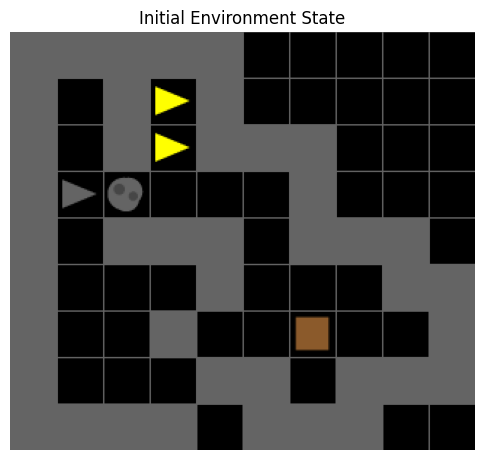

In [11]:
# Render the environment (initial state)
import matplotlib.pyplot as plt

img = env.render(mode='rgb_array', highlight=False)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title('Initial Environment State')
plt.axis('off')
plt.show()

## 4. State Management

EMPO extends MultiGrid with explicit state management. Let's explore the state representation.

In [12]:
# Get the current state
state = env.get_state()

print("State format: (step_count, agent_states, mobile_objects, mutable_objects)")
print(f"\nCurrent state:")
print(f"  Step count: {state[0]}")
print(f"  Agent states: {state[1]}")
print(f"  Mobile objects: {state[2]}")
print(f"  Mutable objects: {state[3]}")

State format: (step_count, agent_states, mobile_objects, mutable_objects)

Current state:
  Step count: 0
  Agent states: ((3, 1, 0, False, True, False, None, None, None), (3, 2, 0, False, True, False, None, None, None), (1, 3, 0, False, True, False, None, None, None))
  Mobile objects: (('block', 6, 6), ('rock', 2, 3))
  Mutable objects: ()


In [13]:
# Take a step and observe state change
actions = [env.actions.forward] * len(env.agents)  # All agents move forward
obs, rewards, done, info = env.step(actions)

new_state = env.get_state()
print(f"After step:")
print(f"  Step count: {new_state[0]}")
print(f"  Done: {done}")

After step:
  Step count: 1
  Done: False


In [15]:
# Restore the original state
env.set_state(state)
restored_state = env.get_state()
print(f"State restored: {state == restored_state}")

State restored: True


## 5. Compute the State DAG

For finite environments, EMPO can compute the complete state-space DAG (Directed Acyclic Graph).

In [16]:
# Create a very small environment for DAG computation (reduce max_steps for speed)
from multigrid_worlds.one_or_three_chambers import SmallOneOrThreeChambersMapEnv

small_env = SmallOneOrThreeChambersMapEnv()
small_env.max_steps = 2  # Very small for quick demo
small_env.reset()

print(f"Environment for DAG: {small_env.width}x{small_env.height} grid, {small_env.max_steps} max steps")

Environment for DAG: 10x9 grid, 2 max steps


In [17]:
# Compute the DAG
import time

print("Computing state DAG...")
t0 = time.time()

# get_dag() returns 3 values by default: states, state_to_idx, successors
# Pass return_probabilities=True to also get transition probabilities as a 4th value
states, state_to_idx, successors = small_env.get_dag()

print(f"✓ DAG computed in {time.time() - t0:.2f}s")
print(f"  Total states: {len(states)}")
print(f"  Terminal states: {sum(1 for s in successors if len(s) == 0)}")
print(f"  Total transitions: {sum(len(s) for s in successors)}")

Computing state DAG...


Building DAG (t=2): : 221 states [00:00, 258.82 states/s]

✓ DAG computed in 0.86s
  Total states: 221
  Terminal states: 184
  Total transitions: 1431


## 6. Compute Human Policy Prior

The core EMPO computation: computing human policy priors via backward induction.

In [18]:
from typing import Iterator, Tuple

# Define a simple goal: reaching a specific cell
class ReachCellGoal(PossibleGoal):
    """A goal where a specific human agent tries to reach a specific cell."""

    def __init__(self, world_model, human_agent_index: int, target_pos: tuple):
        super().__init__(world_model)
        self.human_agent_index = human_agent_index
        self.target_pos = np.array(target_pos)

    def is_achieved(self, state) -> int:
        """Returns 1 if the agent is at the target position, 0 otherwise."""
        step_count, agent_states, mobile_objects, mutable_objects = state

        if self.human_agent_index < len(agent_states):
            agent_state = agent_states[self.human_agent_index]
            pos_x, pos_y = agent_state[0], agent_state[1]
            if pos_x == self.target_pos[0] and pos_y == self.target_pos[1]:
                return 1
        return 0

    def __str__(self):
        return f"ReachCell({self.human_agent_index}->({self.target_pos[0]},{self.target_pos[1]}))"

    def __hash__(self):
        return hash((self.human_agent_index, self.target_pos[0], self.target_pos[1]))

    def __eq__(self, other):
        if not isinstance(other, ReachCellGoal):
            return False
        return (self.human_agent_index == other.human_agent_index and
                np.array_equal(self.target_pos, other.target_pos))

In [19]:
# Define a goal generator that creates goals for reachable cells
class SimpleCellGoalGenerator(PossibleGoalGenerator):
    """Generates goals for a few reachable cells."""

    def __init__(self, world_model):
        super().__init__(world_model)

        # Find empty cells (not walls)
        self.empty_cells = []
        for x in range(world_model.width):
            for y in range(world_model.height):
                cell = world_model.grid.get(x, y)
                if cell is None or (hasattr(cell, 'type') and cell.type != 'wall'):
                    self.empty_cells.append((x, y))

        # Limit to first 5 cells for demo speed
        self.empty_cells = self.empty_cells[:5]
        print(f"Goal generator: {len(self.empty_cells)} target cells")

    def generate(self, state, human_agent_index: int) -> Iterator[Tuple[PossibleGoal, float]]:
        """Yields goals with equal probability weights."""
        total_goals = len(self.empty_cells)
        if total_goals == 0:
            return

        weight = 1.0 / total_goals
        for pos in self.empty_cells:
            goal = ReachCellGoal(self.world_model, human_agent_index, pos)
            yield goal, weight

In [20]:
# Identify human agents (yellow color)
human_agent_indices = []
for i, agent in enumerate(small_env.agents):
    if agent.color == 'yellow':
        human_agent_indices.append(i)

print(f"Found {len(human_agent_indices)} human agent(s): {human_agent_indices}")

Found 2 human agent(s): [0, 1]


In [21]:
# Create goal generator
small_env.reset()
goal_generator = SimpleCellGoalGenerator(small_env)

Goal generator: 5 target cells


In [22]:
# Compute human policy prior using backward induction
print("Computing human policy prior...")
t0 = time.time()

human_policy_prior = compute_human_policy_prior(
    world_model=small_env,
    human_agent_indices=human_agent_indices,
    possible_goal_generator=goal_generator,
    parallel=False,  # Single-threaded for Colab compatibility
    level_fct=lambda state: state[0]  # Use step_count for level computation
)

print(f"✓ Human policy prior computed in {time.time() - t0:.2f}s")
print(f"  Type: {type(human_policy_prior).__name__}")

Computing human policy prior...


Building DAG (t=2): : 221 states [00:00, 280.10 states/s]



Memory estimate:
  States: 221
  Transitions: 0.4 MB
  Vh values: 0.7 MB
  Policies: 0.4 MB
  TOTAL: 7.0 MB

Converting transitions to float16...


Backward induction: 100%|██████████| 221/221 [00:00<00:00, 261.42states/s]


✓ Human policy prior computed in 1.79s
  Type: TabularHumanPolicyPrior


In [23]:
# Test the policy prior
if len(human_agent_indices) > 0:
    small_env.reset()
    initial_state = small_env.get_state()
    first_human_idx = human_agent_indices[0]

    # Get first goal
    first_goal = None
    for goal, weight in goal_generator.generate(initial_state, first_human_idx):
        first_goal = goal
        break

    if first_goal:
        action_probs = human_policy_prior(initial_state, first_human_idx, first_goal)
        print(f"\nAction probabilities for {first_goal}:")
        for action_idx, prob in enumerate(action_probs):
            action_name = small_env.actions.available[action_idx] if action_idx < len(small_env.actions.available) else f"action_{action_idx}"
            print(f"  {action_name}: {prob:.4f}")


Action probabilities for ReachCell(0->(1,1)):
  still: 0.2500
  left: 0.2500
  right: 0.2500
  forward: 0.2500


## 7. Visualize Results

Let's visualize a sample episode with random actions.

In [24]:
# Create a sample episode
env.reset()
frames = [env.render(mode='rgb_array', highlight=False)]

done = False
step = 0
max_steps = 10

while not done and step < max_steps:
    actions = [env.action_space.sample() for _ in env.agents]
    obs, rewards, done, info = env.step(actions)
    frames.append(env.render(mode='rgb_array', highlight=False))
    step += 1

print(f"Generated {len(frames)} frames over {step} steps")

Generated 11 frames over 10 steps


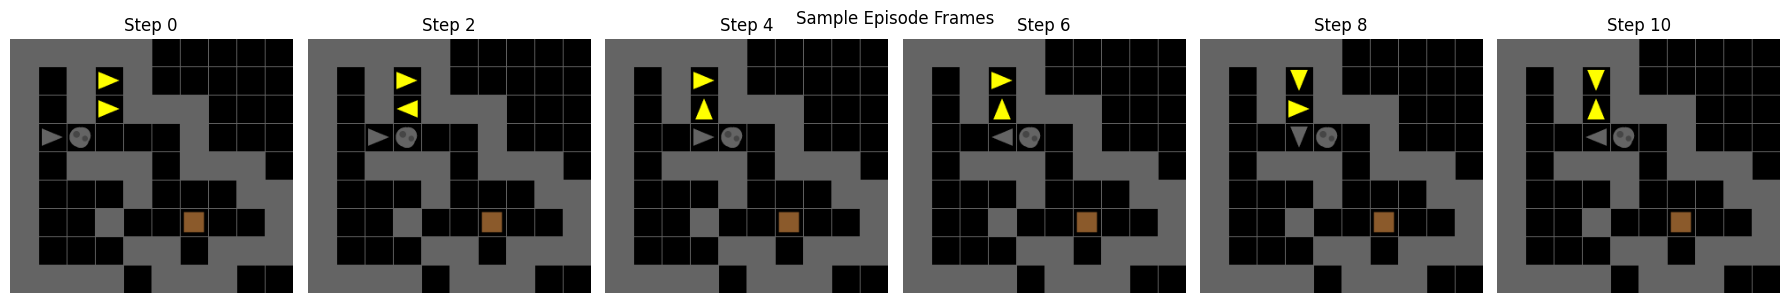

In [25]:
# Display frames as a grid
n_frames = min(6, len(frames))
fig, axes = plt.subplots(1, n_frames, figsize=(3*n_frames, 3))

for i, ax in enumerate(axes):
    idx = i * (len(frames) - 1) // (n_frames - 1) if n_frames > 1 else 0
    ax.imshow(frames[idx])
    ax.set_title(f'Step {idx}')
    ax.axis('off')

plt.tight_layout()
plt.suptitle('Sample Episode Frames', y=1.02)
plt.show()

## 8. Optional Features

### GPU Acceleration
Colab provides free GPU access. The EMPO framework automatically uses GPU when available for neural network computations.

In [26]:
# Check GPU status and create a simple tensor
if torch.cuda.is_available():
    x = torch.randn(1000, 1000, device='cuda')
    print(f"✓ GPU tensor created: {x.shape} on {x.device}")
else:
    print("No GPU available - using CPU mode")
    print("To enable GPU: Runtime > Change runtime type > Hardware accelerator > GPU")

✓ GPU tensor created: torch.Size([1000, 1000]) on cuda:0


### Neural Policy Prior Training Demo
This cell demonstrates training a neural policy prior using the `nn_based` package with GPU support.

In [27]:
# Neural Policy Prior Training using the EMPO nn_based package (update after Jan 25 codebase refactor: from nn_based to learning_based)
# This uses the same training infrastructure as examples/random_multigrid_ensemble_demo.py

import time
import random
import os
import torch

# Import EMPO neural network training components
from empo.world_specific_helpers.multigrid import MultiGridGoalSampler
from empo.learning_based.multigrid import (
    train_multigrid_neural_policy_prior,
    MultiGridQNetwork,
)

# Device selection - use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training on: {device}")
if device == 'cuda':
    print(f"  GPU: {torch.cuda.get_device_name(0)}")

# Create a small environment for training demo
# Using the same environment from earlier but with reduced max_steps for faster training
from multigrid_worlds.one_or_three_chambers import SmallOneOrThreeChambersMapEnv

train_env = SmallOneOrThreeChambersMapEnv()
train_env.max_steps = 10  # Short episodes for demo
train_env.reset()

# Identify human agents (yellow color)
train_human_indices = [i for i, agent in enumerate(train_env.agents) if agent.color == 'yellow']
print(f"Human agents: {train_human_indices}")
print(f"Grid size: {train_env.width}x{train_env.height}")

# Create goal sampler - samples goals weighted by area
goal_sampler = MultiGridGoalSampler(train_env)

# Set random seeds for reproducibility
random.seed(42)
torch.manual_seed(42)

# Setup TensorBoard logging
from torch.utils.tensorboard import SummaryWriter
log_dir = 'outputs/neural_policy_training'
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)
print(f"TensorBoard logs: {log_dir}")

# Train the neural policy prior
# This uses Q-learning with experience replay, similar to the demo scripts
print("\nTraining neural policy prior (50 episodes for demo)...")
t0 = time.time()

neural_prior = train_multigrid_neural_policy_prior(
    world_model=train_env,
    human_agent_indices=train_human_indices,
    goal_sampler=goal_sampler,
    num_episodes=50,           # Short training for demo (use 500+ for real training)
    steps_per_episode=10,      # Match max_steps
    batch_size=32,
    learning_rate=1e-3,
    gamma=0.99,                # Discount factor
    beta=100.0,                # Boltzmann temperature (higher = more deterministic)
    replay_buffer_size=5000,
    updates_per_episode=2,
    epsilon=0.3,               # Exploration rate
    reward_shaping=True,       # Use path-based reward shaping
    device=device,
    verbose=True
)

elapsed = time.time() - t0
print(f"\n✓ Training completed in {elapsed:.2f}s")
print(f"  Q-network type: {type(neural_prior.q_network).__name__}")
print(f"  Total parameters: {sum(p.numel() for p in neural_prior.q_network.parameters()):,}")

# Log training metrics to TensorBoard
writer.add_scalar('Training/elapsed_time', elapsed, 0)
writer.add_scalar('Training/num_parameters', sum(p.numel() for p in neural_prior.q_network.parameters()), 0)

# Log weight histograms
for name, param in neural_prior.q_network.named_parameters():
    writer.add_histogram(f'Weights/{name}', param.data, 0)

writer.flush()
print(f"\n✓ TensorBoard logs written to: {log_dir}")

Training on: cuda
  GPU: Tesla T4
Human agents: [0, 1]
Grid size: 10x9
TensorBoard logs: outputs/neural_policy_training

Training neural policy prior (50 episodes for demo)...


Training: 100%|██████████| 50/50 [00:17<00:00,  2.79episodes/s]


✓ Training completed in 23.39s
  Q-network type: MultiGridQNetwork
  Total parameters: 438,980

✓ TensorBoard logs written to: outputs/neural_policy_training


In [28]:
# Test the trained policy by getting action probabilities and sampling
from empo.world_specific_helpers.multigrid import ReachCellGoal
import torch.nn.functional as F

train_env.reset()
test_state = train_env.get_state()

# Create a test goal (reach cell 3,3)
if train_human_indices:
    test_human_idx = train_human_indices[0]
    test_goal = ReachCellGoal(train_env, test_human_idx, (3, 3))

    # Get action probabilities from the trained network (returns dict)
    action_probs_dict = neural_prior(test_state, test_human_idx, test_goal)

    # Get action names from environment
    if hasattr(train_env, 'actions') and hasattr(train_env.actions, 'available'):
        action_names = train_env.actions.available
    else:
        action_names = [f'action_{i}' for i in range(len(action_probs_dict))]

    print(f"Action probabilities for human {test_human_idx} to reach (3,3):")
    for action_idx in sorted(action_probs_dict.keys()):
        prob = action_probs_dict[action_idx]
        name = action_names[action_idx] if action_idx < len(action_names) else f'action_{action_idx}'
        print(f"  {name}: {prob:.4f}")

    # Sample action using the Q-network directly (Boltzmann sampling with beta=100)
    # This is how examples/random_multigrid_ensemble_demo.py samples actions
    with torch.no_grad():
        q_values = neural_prior.q_network.forward(
            test_state, train_env, test_human_idx, test_goal, device
        )
        # Boltzmann sampling with beta=100
        q_values = q_values - torch.max(q_values, dim=1, keepdim=True).values  # Numerical stability
        policy = F.softmax(100.0 * q_values, dim=1)
        sampled_action = torch.multinomial(policy, 1).item()

    sampled_name = action_names[sampled_action] if sampled_action < len(action_names) else f'action_{sampled_action}'
    print(f"\nSampled action (using neural_prior.q_network): {sampled_name}")

    # Log test results to TensorBoard
    for action_idx, prob in action_probs_dict.items():
        writer.add_scalar(f'TestPolicy/action_{action_idx}_prob', prob, 0)
    writer.flush()

ModuleNotFoundError: No module named 'empo.multigrid'

### View TensorBoard
View the training metrics logged above.

In [ ]:
# Load TensorBoard extension and display logs
%load_ext tensorboard
%tensorboard --logdir outputs/neural_policy_training

### Weights & Biases Integration (Optional)
For more advanced experiment tracking.

In [ ]:
# Uncomment to install and use W&B
# !pip install -q wandb
# import wandb
# wandb.login()  # Requires API key

## 9. Caveats and Limitations in Colab

### Not Supported:
- **MPI distributed training**: Colab doesn't support MPI. Use single-process mode (`parallel=False`).
- **Docker**: Colab runs in a containerized environment; you can't run Docker inside it.
- **Long-running jobs**: Colab sessions timeout after ~12 hours (or sooner for free tier).

### Workarounds:
- For large state spaces, reduce `max_steps` or use smaller environments.
- Save checkpoints frequently to Google Drive.
- Use `parallel=False` for backward induction to avoid multiprocessing issues.

### Tips:
- Enable GPU for faster neural network training: Runtime > Change runtime type > GPU
- Mount Google Drive to persist data across sessions
- Use `%%time` magic to profile cell execution

In [ ]:
# Example: Mount Google Drive for data persistence
# Uncomment to use:
# from google.colab import drive
# drive.mount('/content/drive')
#
# # Save outputs to Drive
# import shutil
# shutil.copytree('outputs', '/content/drive/MyDrive/empo_outputs')

## Summary

This notebook demonstrated:

1. **Setup**: Cloning the repo, installing dependencies, configuring PYTHONPATH
2. **Environment**: Creating and exploring MultiGrid environments
3. **State Management**: Using `get_state()` and `set_state()` for exact state control
4. **DAG Computation**: Computing the state-space structure
5. **Policy Priors**: Computing human policy priors via backward induction
6. **Visualization**: Rendering environment states
7. **Neural Network Training**: GPU-accelerated training with TensorBoard logging

For more information, see:
- [GitHub Repository](https://github.com/mensch72/empo)
- [API Documentation](https://github.com/mensch72/empo/blob/main/docs/API.md)
- [README](https://github.com/mensch72/empo/blob/main/README.md)

In [ ]:
print("\n" + "="*60)
print("EMPO Colab Demo Complete!")
print("="*60)